<a href="https://www.kaggle.com/code/salimhammadi07/kenyan-sign-language-classification-challenge?scriptVersionId=103760761" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Description

A common misconception of sign language is that it is the same everywhere; in reality there are as many as 300 different languages (approximately 50 of these from Africa) with new signs evolving each day as a need appears. Kenyan Sign Language (KSL) is used in Kenya and Somalia, and there are different dialects depending on what region you are in. It is used by over half of Kenya's estimated 600 000-strong deaf population.

The objective of this competition is to build a model to recognise ten different everyday KSL signs present in the images, using machine learning or deep learning algorithms.

This dataset was collected specifically for a Zindi competition. Almost all of the hands are hands of people of colour, in an effort to address bias in sign language datasets. In this effort, the dataset is a public good and open to all to use. We encourage all solutions and derivatives of this dataset to be shared publicly as a public good to the sector.

# Imports

In [1]:
# Supress unnecessary warnings so that the presentation looks clean
import warnings
warnings.filterwarnings("ignore")

import os
from fastai.vision.all import *
import torch
import random

# Setup

Assuming provided files are present. Installing fastai (may need to restart runtime)

In [2]:
!pip install -qU fastcore fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have p

In [3]:
import fastai
fastai.__version__

'2.5.3'

# Load data and put in dataloaders

Fastai makes it relatively easy to get our training data from the dataframe into a format we can use for training.

In [4]:
# Set the seed value all over the place to make this reproducible.
seed  = 42

def seed_value(SEED):
  random.seed(seed)
  np.random.seed(save_model)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [5]:
train = pd.read_csv('../input/kslc-dataset/Train.csv')
print(train.shape)
train.head(2)

(6249, 2)


,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church


In [6]:
test = pd.read_csv('../input/kslc-dataset/Test.csv')
print(test.shape)
test.head(2)

(2679, 1)


,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI


In [7]:
# Add the image filenames (will be useful)
train['fn'] = train['img_IDS'].map(lambda s: '../input/kslc-dataset/Images/Images/'+'_'.join(s.split('_')[:2]))
test['fn'] = test['img_IDS'].map(lambda s: '../input/kslc-dataset/Images/Images/'+'_'.join(s.split('_')[:2]))

# class distribution

<AxesSubplot:>

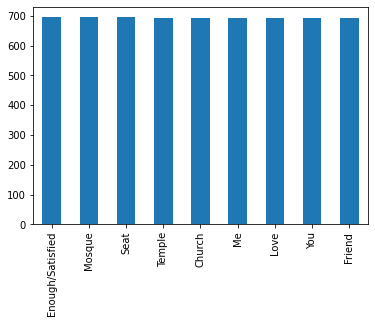

In [8]:
train['Label'].value_counts().plot.bar()

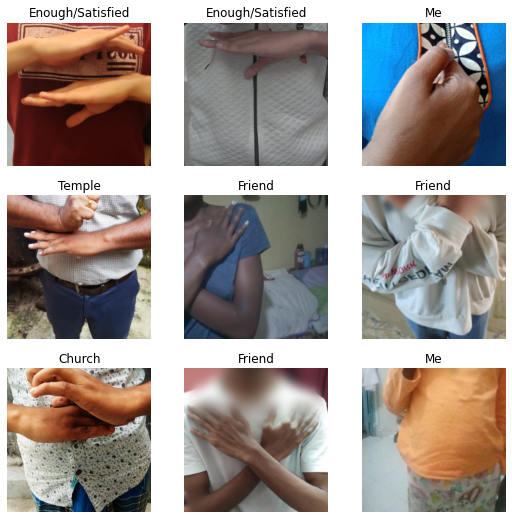

In [9]:
augmentations = [
        Brightness(max_lighting=0.3,p=0.5),
        Contrast(max_lighting=0.4, p=0.5),
        Flip(p=0.5),
    ]
dls = ImageDataLoaders.from_df(train, batch_tfms=augmentations, num_workers=0, bs=64, valid_pct=0.2, fn_col='fn'
                               , label_col='Label', suff='.jpg', item_tfms=Resize(224))
dls.show_batch()

# Quick Model

No fancy training here - this only took a minute, just enough time for me to organise my previous cells a little :)

In [10]:
learn = cnn_learner(dls, models.resnet152, metrics=[error_rate,accuracy,], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

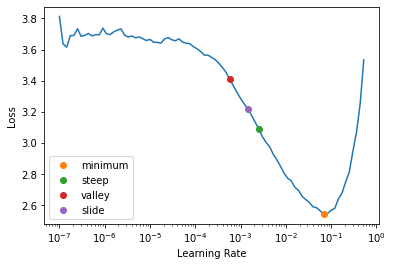

In [11]:
minimum, steep, valley, slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [12]:
learning_rate = minimum
epochs = 15

In [13]:
# learn.fit(epochs, slice(minimum))
# learn.fine_tune(epochs,learning_rate)

In [14]:
learn.fit_one_cycle(epochs, slice(minimum))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.675572,0.911264,0.267414,0.732586,03:01
1,1.097703,0.678518,0.199359,0.800641,02:56
2,0.768822,0.441735,0.132906,0.867094,02:56
3,0.579101,0.423396,0.111289,0.888711,02:56
4,0.492042,0.361347,0.102482,0.897518,02:55
5,0.440377,0.381615,0.111289,0.888711,02:56
6,0.374636,0.325322,0.101681,0.898319,02:55
7,0.331306,0.366984,0.108887,0.891113,02:56
8,0.282903,0.302347,0.086469,0.913531,02:59
9,0.267188,0.310639,0.096878,0.903122,02:55


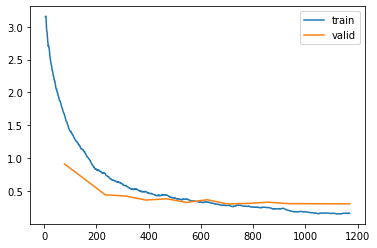

In [15]:
learn.recorder.plot_loss()

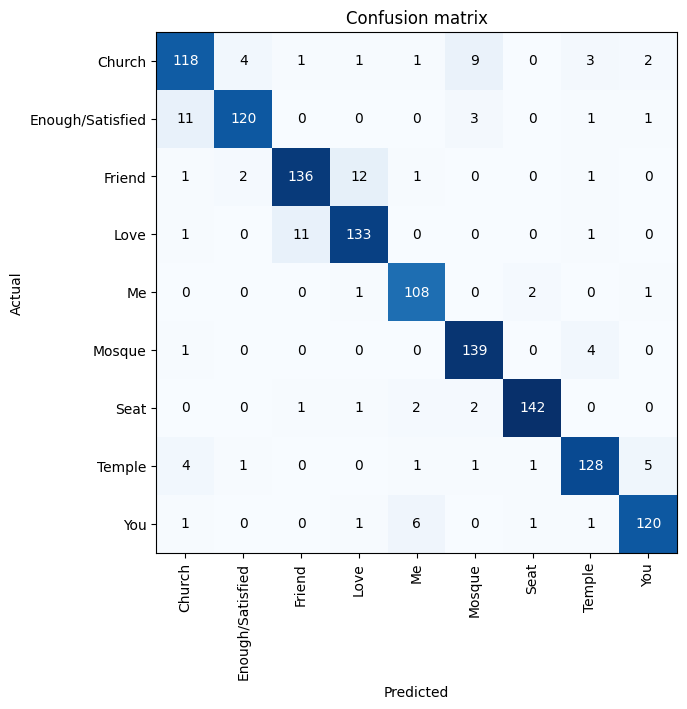

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7, 7), dpi=100)

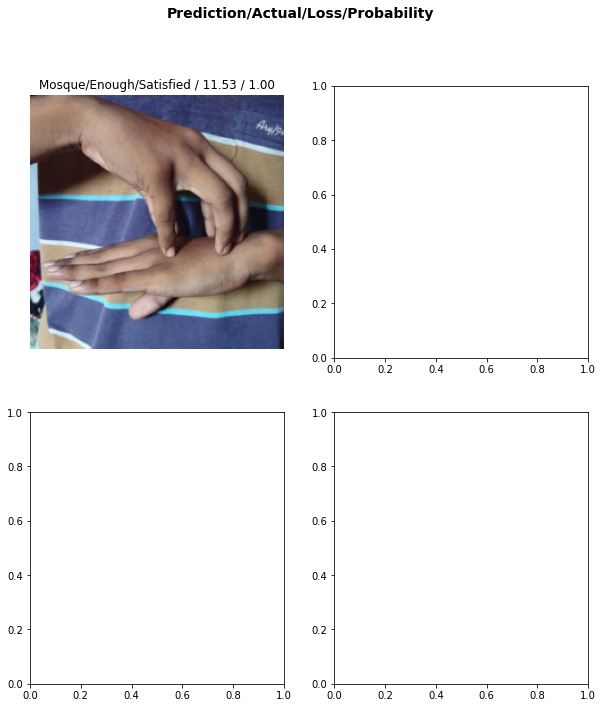

In [17]:
interp.plot_top_losses(4, figsize=(10,11))

# Submission

In [18]:
preds = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities

In [19]:
sub=pd.read_csv('../input/kslc-dataset/SampleSubmission.csv')
k=[]
for col in sub.columns:
    k.append(col) # creating list of the label

In [20]:
cls = ['Church', 'Enough/Satisfied', 'Friend', 'Love', 'Me', 'Mosque', 'Seat', 'Temple', 'You']

In [21]:
submission = pd.DataFrame()
submission["ID"] = test["img_IDS"]
submission[cls]= preds[0]
submission.head(15)

,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,3.284347e-04,1.062380e-06,1.327771e-07,4.300738e-08,3.468973e-07,6.833599e-07,3.717366e-09,9.996692e-01,1.103296e-07
1,ImageID_SZ8D1ZJI,5.822855e-06,9.999843e-01,3.421270e-07,5.118117e-09,1.026200e-08,3.889796e-06,8.519954e-09,5.645152e-06,1.295365e-08
2,ImageID_4OJO2F8J,9.799218e-03,1.978843e-05,1.601837e-04,3.982557e-04,2.213089e-04,9.893160e-01,4.418982e-07,8.045199e-05,4.381941e-06
3,ImageID_IEE4XV0B,1.327928e-03,1.894155e-06,5.176580e-05,1.871937e-05,4.194079e-06,9.985878e-01,3.493750e-06,3.828339e-06,3.802633e-07
4,ImageID_BP0O0WZ9,2.417129e-02,5.227980e-04,4.496463e-03,1.369667e-02,8.872703e-02,1.051618e-03,5.015751e-02,1.613122e-03,8.155635e-01
5,ImageID_M0V58H3K,9.999219e-01,5.476846e-05,3.405477e-07,3.913163e-07,3.316518e-06,3.350965e-06,2.952112e-09,1.596522e-05,2.823408e-08
6,ImageID_R87BQKKT,7.381017e-07,2.409519e-06,1.952371e-01,8.046831e-01,1.005989e-05,1.382341e-06,5.737285e-05,4.825471e-07,7.477811e-06
7,ImageID_MX5UE68W,1.680835e-12,1.849241e-10,1.000000e+00,6.263253e-11,1.911882e-12,1.278320e-11,8.750667e-12,3.089540e-13,6.028590e-14
8,ImageID_3AAK0323,2.271126e-05,4.248707e-05,4.314513e-01,5.678236e-01,2.552952e-04,2.622846e-05,1.714167e-04,4.454251e-05,1.624656e-04
9,ImageID_F3G4F52P,6.793745e-11,6.890854e-11,4.417818e-14,5.509755e-11,1.979848e-10,9.640060e-13,1.428795e-09,2.920156e-10,1.000000e+00


In [22]:
submission.to_csv('sub.csv', index=False)